# Quantitative Analysis (SIMIND)

In this tutorial, we'll reconstruct SIMIND simulation data using OSEM, and use noise-bias curves to evaluate its performance as a function of iteration.

In [1]:
import os
import torch
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import pytomography
from pytomography.algorithms import OSEM
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projectors import SPECTSystemMatrix
from pytomography.callbacks import CallBack
from pytomography.io.SPECT import simind

Modify the path below to where you saved the files:

In [2]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/' 

# Part 1: Open Projection Data

Like in the first SIMIND tutorial, we'll start by opening our projection data

In [3]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
activity_dict = {organ: activity for organ, activity in zip(organs, activities)}
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
object_meta, proj_meta = simind.get_metadata(headerfiles[0])
projections = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)

Now lets make them representative of a real scan where each projection is taken for 15 s, like we did in the first SIMIND tutorial

In [4]:
dT = 15 #s
projections *= dT
scatter *= dT
projections = torch.poisson(projections)
scatter = torch.poisson(scatter)

And plot

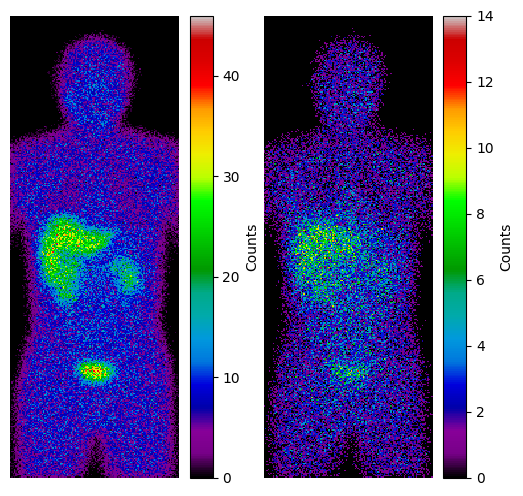

In [5]:
plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
plt.pcolormesh(projections[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')
plt.subplot(122)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')

These reconstructions can be reconstructed as shown in the introductory SIMIND tutorial. The goal of this tutorial, however, is to perform a quantitative analysis on the accuracy of the reconstruction, given that we know the ground truth distribution.

## 2. Obtain Organ Masks

We need to start by creating 3D organ masks for each of the different simulated regions in SIMIND. We'll start by getting access to all the ground truth files used to simulate each seperate region.

The following code creates 4 things:

1. `mask`: An object of shape (1,128,128,384) where each voxel is an integer signifying which region it is in. For example, a voxel with integer `2` corresponds to liver. This requires opening the GT images of shape (756,512,512), transposing/resizing these images to shape (128,128,384), and building a mask.
2. `mask_idx_dict`: A dictionary which has organs/regions as keys and their corresponding integer value (in `mask`) as values.
3. `organ_vol_dict`: A dictionary which has organs/regions as keys and the corresponding volume of the organ in mL
4. `mask_vol_dict`:  A dictionary which has organs/regions as keys and the corresponding volume of the organ mask in mL. Note that this is different from `organ_vol_dict` since the `mask` only includes voxels that are completely inside the organ (see plot below)

In [6]:
GTfiles = [os.path.join(path, 'phantom_organs', f'{organ}_act_av.bin') for organ in organs]
GT_shape = (768,512,512)
GT_spacing = (0.15,0.075,0.075) #cm
mask = np.zeros(object_meta.shape)
mask_idx_dict = {}
mask_vol_dict = {}
organ_vol_dict = {}
for i, GT_path in enumerate(GTfiles):
    # Open GT file
    GTi = np.fromfile(GT_path, dtype=np.float32)
    # Reshape to 3D dimensions
    GTi = GTi.reshape((768,512,512))
    # Tranpose x/z axis to fit with pytomography standards
    GTi = np.transpose(GTi, (2,1,0))
    # Look for values >0 that specify the mask
    GTi = (GTi>0).astype(np.float32)
    # Find the volume of the organ (in mL)
    organ_vol_dict[organs[i]] = GTi.sum() * np.prod(GT_spacing)
    # Resize the mask to be the same shape as the reconstructed object
    GTi = resize(GTi, object_meta.shape, anti_aliasing=True)
    # Take only voxels that lie entirely inside the organ/region
    GTi = GTi>=1
    # Find the volume of the organ mask (in mL)
    mask_vol_dict[organs[i]] = GTi.sum() * np.prod(object_meta.dr)
    # Update the mask
    mask[GTi] = i+1
    mask_idx_dict[organs[i]] = i+1

The `mask` can be viewed below. Note that the masks only include voxels that don't overlap boundaries

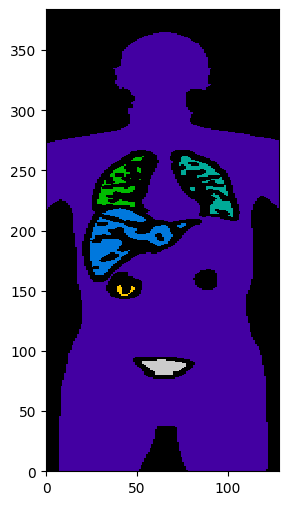

In [7]:
plt.figure(figsize=(3,6))
plt.pcolormesh(mask[:,64].T, cmap='nipy_spectral')

## Part 3: Reconstructing SPECT Data

Now we will reconstruct our SPECT data, and compare it to the original phantom. In particular, since we're using an iterative algorithm, we'll want to see how the improvements as a function of iterations. We'll get to that later.

In [8]:
attenuation_map = simind.get_attenuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta)

Next we'll create a subclass of the `CallBack` class to compute statistics during the reconstruction after each iteraton.

In [9]:
class CompareToGroundTruth(CallBack):
    def __init__(self, organs, mask, mask_idx_dict, mask_vol_dict):
        self.organs = organs
        self.mask = mask
        self.mask_idx_dict = mask_idx_dict
        self.mask_vol_dict = mask_vol_dict
        self.avg_counts_per_mL = {organ: [] for organ in organs}
        self.std_counts_per_mL = {organ: [] for organ in organs}
    def run(self, obj, n_iter):
        # In this case n_iter isnt used since the callback is called every iteration
        for organ in organs:
            # Compute the counts/mL for each voxel in the organ
            counts_per_mL = obj[0][self.mask==self.mask_idx_dict[organ]] / np.prod(object_meta.dr)
            # Compute average counts/mL and standard deviation of counts/mL in the organ
            avg_counts_per_mL = counts_per_mL.mean().item()
            std_counts_per_mL = counts_per_mL.std().item()
            # Append these 
            self.avg_counts_per_mL[organ].append(avg_counts_per_mL)
            self.std_counts_per_mL[organ].append(std_counts_per_mL)

Now create an instance of the callback and use it in a reconstruction algorithm:

* Note, we are running for 80 iterations; this may take a few minutes depending on your graphics card

In [10]:
callback = CompareToGroundTruth(organs, mask, mask_idx_dict, mask_vol_dict)
reconstruction_algorithm = OSEM(projections, system_matrix, scatter=scatter)
reconstructed_object = reconstruction_algorithm(n_iters=80, n_subsets=8, callback=callback)

The reconstructed object has units of counts. If we want to convert to MBq, we need to normalize based on the total activity injected 

* In clinical practice, this normalization factor can be obtained by scanning a point source of known activity (in MBq) and then dividing the total number of counts detected by the known activity

In [11]:
counts_to_MBq = sum(activities) / reconstructed_object.sum().item()

Let's visualize a coronal slice of the reconstructed objects.

* We'll convert to units of MBq/mL by multiple the array of counts by the `counts_to_MBq` conversion factor, and then dividing by the voxel volume

In [12]:
o1 = reconstructed_object[0][:,64].cpu().numpy().T * counts_to_MBq / np.prod(object_meta.dr)

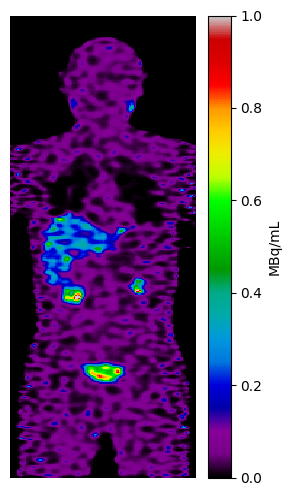

In [13]:
plt.figure(figsize=(3,6))
plt.pcolormesh(o1,cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar(label='MBq/mL')

Finally, here's some code written to plot/compare noise-bias curves for each reconstruction algorithm.

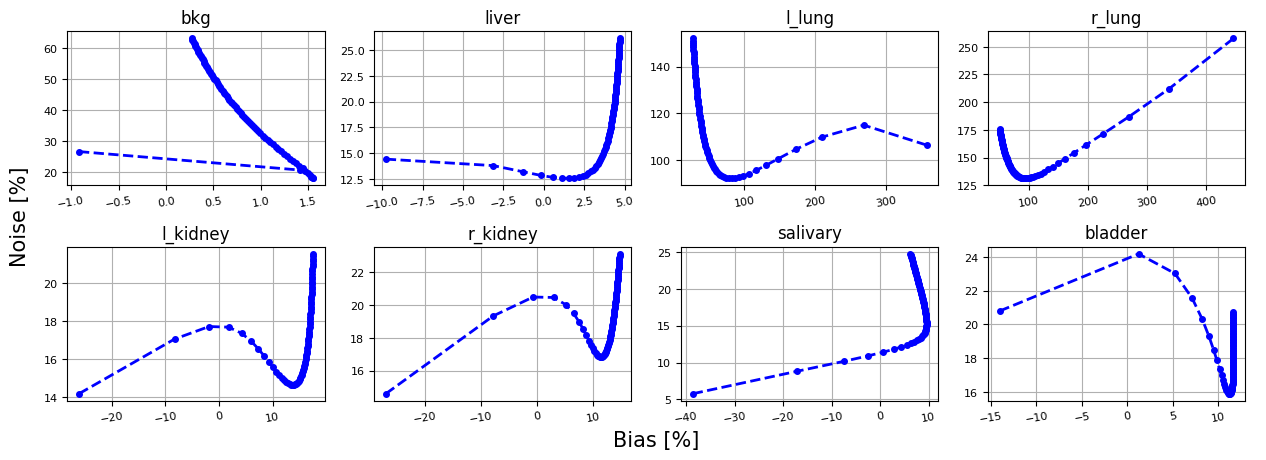

In [14]:
def plot_bvc(callback, organ, ax, color):
    activity_MBQ_per_mL = np.array(callback.avg_counts_per_mL[organ]) * counts_to_MBq
    activity_noise_MBQ_per_mL = np.array(callback.std_counts_per_mL[organ]) * counts_to_MBq
    true_activity_MBQ_per_mL = activity_dict[organ] / organ_vol_dict[organ]
    activity_bias_pct = 100 * activity_MBQ_per_mL / true_activity_MBQ_per_mL - 100
    activity_noise_pct = 100 * activity_noise_MBQ_per_mL / true_activity_MBQ_per_mL
    ax.plot(activity_bias_pct, activity_noise_pct, ls='--', marker='o', markersize=4, lw=2, color=color)

fig, axes = plt.subplots(2, 4, figsize=(13,5))
for ax, organ in zip(axes.ravel(), organs):
    plot_bvc(callback, organ, ax, 'blue')
    ax.grid()
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='x', which='major', labelsize=8, rotation=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(organ)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Bias [%]", fontsize=15)
plt.ylabel("Noise [%]", fontsize=15)
fig.tight_layout()

These noise-bias curves can be compared between various reconstruction algorithms to assess the capabilities of each algorithm.